# Комп'ютерний Практикум 2 з Криптоаналізу.

**Тема:** Статистичнi критерiї на вiдкритий текст

**Виконали:** Бондар Петро, Кістаєв Матвій.

**Варіант:** 4

In [1]:
from pypdf import PdfReader
import itertools
import numpy as np
import random
import lzma
import deflate
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

## Завантаження текстів

Як джерело змістовних повідомлень було обрано тексти Конституції України, "Енеїди" Котляревського, "Хто ти?" Артема Чеха та бакалаврські роботи авторів цієї лабораторної роботи (видатних вчених, між іншим).

In [2]:
folder = "documents"
ukr_texts = ["Конституція.pdf", "Енеїда.pdf", "Кучма.pdf", "Хто.pdf", "Bondar_bakalavr.pdf", "Kistaiev_bakalavr.pdf"]

large_text = ""

for text in ukr_texts:
    reader = PdfReader(f"{folder}/{text}")
    for page in reader.pages:
        large_text += page.extract_text() + "\n"


## Обробка текстів та створення змінних для перетворення текстових даних у числові

In [3]:
alph_full = list('АаБбВвГгҐґДдЕеЄєЖжЗзИиІіЇїЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЬьЮюЯя')
alph_1 = list(' абвгґдеєжзиіїйклмнопрстуфхцчшщьюя')
alph_2 = [f'{c1}{c2}' for c1, c2 in itertools.product(alph_1, alph_1)]
lang = []

for c in large_text:
    if c in alph_full:
        lang.append(str.lower(c))
    elif lang[-1] != ' ':
        lang.append(' ')

alph = [' '] + alph_full
lang = "".join(lang)

ARING1 = dict(zip(list(alph_1), range(len(alph_1))))
ARING2 = dict(zip(list(alph_2), range(len(alph_2))))

## Підрахунок частот символів та біграм в текстах українською мовою

In [4]:
n = len(lang)

lang_1_shreq = dict(zip(alph_1, [0]*len(alph_1)))
for c in lang:
    lang_1_shreq[c] += 1

lang_1_shreq = {key: val / (n - 1) for key, val in lang_1_shreq.items()}


lang_2_shreq = dict(zip(alph_2, [0]*len(alph_2)))
for c1, c2 in zip(lang[:-1], lang[1:]):
    lang_2_shreq[f'{c1}{c2}'] += 1

lang_2_shreq = {key: val / (n - 1) for key, val in lang_2_shreq.items()}

print(n)
print(lang_1_shreq)
print(lang_2_shreq)

2225382
{' ': 0.15635974244410283, 'а': 0.06886146686792059, 'б': 0.014084329829364051, 'в': 0.04702655410466792, 'г': 0.013156848198128769, 'ґ': 3.055656537015459e-05, 'д': 0.027879271010222518, 'е': 0.03994866497017814, 'є': 0.003587250902205061, 'ж': 0.007517813803568917, 'з': 0.01869387758770296, 'и': 0.05343489496854696, 'і': 0.04630173439963763, 'ї': 0.007580275018075557, 'й': 0.010577514591883367, 'к': 0.032522071501464245, 'л': 0.031105235463051047, 'м': 0.025339930555711584, 'н': 0.05820801022386728, 'о': 0.08053497356183054, 'п': 0.023567649764242617, 'р': 0.040964221407480336, 'с': 0.03807977150878883, 'т': 0.04143200647439697, 'у': 0.03007440074306377, 'ф': 0.0022328760782985026, 'х': 0.009462649317128168, 'ц': 0.0072585323591780465, 'ч': 0.010776132266789373, 'ш': 0.006870284234474906, 'щ': 0.004235229832554515, 'ь': 0.0156588916684379, 'ю': 0.0071695588306002435, 'я': 0.019467228308321136}
{'  ': 0.0, ' а': 0.003484796535963954, ' б': 0.0060928892625577375, ' в': 0.014814

## Шифрування, використовувані для спотворення тексту

Для утворення беззмістовних текстів з природніх ми використовуватимо шифр Віженера, а також афінну та біграмну афінну підстановки.

In [5]:
def vigenere_encrypt(ptext: str, key: str):
    r = int(np.ceil(len(ptext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ptext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt + nkey) % len(alph_1)])


def vigenere_decrypt(ctext: str, key: str):
    r = int(np.ceil(len(ctext) / len(key)))

    ntxt = np.array([ARING1[c] for c in ctext])
    nkey = np.array([ARING1[c] for c in key] * r)

    return "".join([alph_1[c] for c in (ntxt - nkey) % len(alph_1)])


def affine_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_1)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""
    for i in range(0, len(text)):
        id = (a * ARING1[text[i]] + b) % len(alph_1)
        res += alph_1[id]

    return res


def affine_bigram_ecrypt(text: str, a: int, b: int):
    if np.gcd(a, len(alph_2)) != 1:
        raise RuntimeError("Incorrect key, gcd(a, n) != 1")
    
    res = ""

    for c1, c2 in zip(text[:-1], text[1:]):
        id = (a * ARING2[f'{c1}{c2}'] + b) % len(alph_2)
        res += alph_2[id]

    return res

## Генерація випадкових текстів

Беззмістовні тексти ми генеруватимемо наступними методами:
- Чисто випадковий текст, де кожен символ матиме однакову ймовірність появи на кожній позиції;
- Рекурсивна випадкова послідовність, в якій перші два символи обираються випадково, а кожен наступний є комбінацією двох попередніх за модулем;
- Зашифрований за допомогою шифру Віженера відкритий текст (ключ генерується випадково);
- Зашифрований за допомогою афінного шифру відкритий текст (ключ генерується випадково);
- Зашифрований за допомогою біграмного афінного шифру відкритий текст (ключ генерується випадково).

Змістовні тексти ми отримуватимемо шляхом вирізання випадкового шматку з джерела текстів.

In [6]:
def generate_random_text(length):
    return ''.join(random.SystemRandom().choice(alph_1) for _ in range(length))


def generate_recur(length):
    res = ''
    res += random.SystemRandom().choice(alph_1)
    res += random.SystemRandom().choice(alph_1)
    for _ in range(0, length - 1):
        res += alph_1[(ARING1[res[-1]] + ARING1[res[-2]]) % len(alph_1)]
    return res


def generate_rand_lang_text(length):
    i = random.randrange(0, len(lang) - length)

    return "".join(lang[i:i+length])


def generate_enc_vigenere(length, key_len):
    text = generate_rand_lang_text(length)
    key = generate_random_text(key_len)

    return vigenere_encrypt(text, key)


alph_1_divs = np.array([2, 17, 34])
possible_a_1 = [i for i in range(1, len(alph_1)) if all((i % alph_1_divs) != 0)]

def generate_enc_affine1(length):
    text = generate_rand_lang_text(length)
    key_a = random.SystemRandom().choice(possible_a_1)
    key_b = random.SystemRandom().choice(range(len(alph_1)))

    return affine_ecrypt(text, key_a, key_b)
    

alph_2_divs = np.array([2, 17, 34])
possible_a_2 = [i for i in range(1, len(alph_2)) if all((i % alph_2_divs) != 0)]

def generate_enc_affine2(length):
    text = generate_rand_lang_text(length)
    key_a = random.SystemRandom().choice(possible_a_2)
    key_b = random.SystemRandom().choice(range(len(alph_2)))

    return affine_ecrypt(text, key_a, key_b)


## Функції для обробки характеристик обраного тексту

- Функції для підрахунку частот символів та біграм в обраному тексті.
- Функції для обчислення індексу відповідності (аби було) та усередненої ентропії в обраному тексті.
- Функції для обчислення кількості "порожніх якщиків".
- Функція для обчислення коефіцієнтів стиснення за допомогою lzma та deflate.

In [ ]:
def gram_1_shreqs(A, text):
    text_1_shreqs = dict(zip(A, [0]*len(A)))

    for c in text:
        if c in A:
            text_1_shreqs[c] += 1 
    
    return {key: val / (len(text) - 1) for key, val in text_1_shreqs.items()}

def gram_2_shreqs(A, text):
    text_2_shreqs = dict(zip(A, [0]*len(A)))

    for c1, c2 in zip(text[:-1], text[1:]):
        if f'{c1}{c2}' in A:
            text_2_shreqs[f'{c1}{c2}'] += 1 

    return {key: val / (len(text) - 1) for key, val in text_2_shreqs.items()}

def index_of_coincidence(l_gram_counts):
    counts = np.array(list(l_gram_counts.values()))
    N = counts.sum()
    I = sum(count * (count - 1) for count in counts) / (N * (N - 1))

    return I

def avg_entropy(text, l):
    l_gram_shreqs = defaultdict(lambda: 0)

    for i in range(len(text) - l):
        l_gram_shreqs[text[i:i+l]] += 1

    probs = np.array(list(l_gram_shreqs.values())) / (len(text) - l + 1)
    H = -probs.dot(np.log2(probs)) / l

    return H


def n_empty_1_boxes(B_freq, text):
    return sum(np.array(list(gram_1_shreqs(B_freq, text).values())) == 0)

def n_empty_2_boxes(B_freq, text):
    return sum(np.array(list(gram_2_shreqs(B_freq, text).values())) == 0)


def lzma_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = lzma.compress(txt)
    compressed_len = len(ctxt)

    return compressed_len / original_len


def deflate_compression_ratio(text):
    txt = text.encode()
    original_len = len(txt)

    ctxt = deflate.gzip_compress(txt, 12)
    compressed_len = len(ctxt)

    return compressed_len / original_len

## Підготовка до підрахунку та визначення користувацьких змінних

- Заборонені символи та біграми.
- Часті символи та біграми.

{'ґ': 3.055656537015459e-05, 'ф': 0.0022328760782985026, 'є': 0.003587250902205061, 'щ': 0.004235229832554515, 'ш': 0.006870284234474906, 'ю': 0.0071695588306002435, 'ц': 0.0072585323591780465, 'ж': 0.007517813803568917, 'ї': 0.007580275018075557, 'х': 0.009462649317128168, 'й': 0.010577514591883367, 'ч': 0.010776132266789373, 'г': 0.013156848198128769, 'б': 0.014084329829364051, 'ь': 0.0156588916684379}
{'  ': 0.0, 'аь': 0.0, 'бї': 0.0, 'бй': 0.0, 'вґ': 0.0, 'вї': 0.0, 'гб': 0.0, 'гг': 0.0, 'гґ': 0.0, 'гє': 0.0, 'гж': 0.0, 'гї': 0.0, 'гй': 0.0, 'гф': 0.0, 'гх': 0.0, 'гц': 0.0, 'гщ': 0.0, 'гю': 0.0, 'ґ ': 0.0, 'ґб': 0.0, 'ґг': 0.0, 'ґґ': 0.0, 'ґд': 0.0, 'ґє': 0.0, 'ґж': 0.0, 'ґз': 0.0, 'ґи': 0.0, 'ґї': 0.0, 'ґй': 0.0, 'ґк': 0.0, 'ґл': 0.0, 'ґм': 0.0, 'ґп': 0.0, 'ґс': 0.0, 'ґт': 0.0, 'ґф': 0.0, 'ґх': 0.0, 'ґц': 0.0, 'ґч': 0.0, 'ґш': 0.0, 'ґщ': 0.0, 'ґь': 0.0, 'ґю': 0.0, 'ґя': 0.0, 'дї': 0.0, 'дф': 0.0, 'еґ': 0.0, 'еь': 0.0, 'єа': 0.0, 'єб': 0.0, 'єґ': 0.0, 'єе': 0.0, 'єи': 0.0, 'єо': 0.

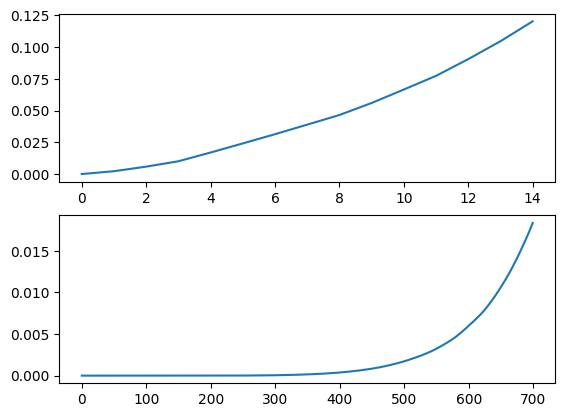

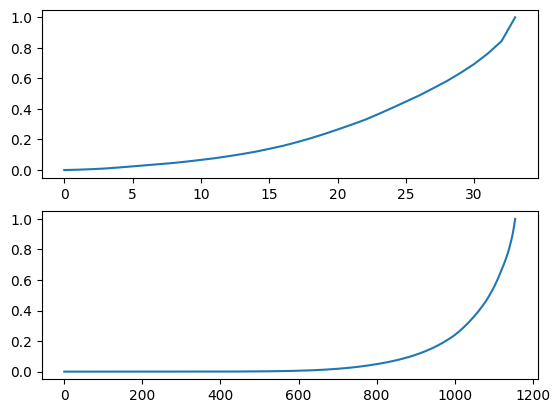

In [8]:
A1_prh = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[0:15]}
print(A1_prh)

A2_prh = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[0:700]}
print(A2_prh)

fig, axs1 = plt.subplots(2, 1)
axs1[0].plot(range(len(A1_prh.keys())), np.cumsum(list(A1_prh.values())))
axs1[1].plot(range(len(A2_prh.keys())), np.cumsum(list(A2_prh.values())))

A1_prh = list(A1_prh.keys())[0:9]
A2_prh = list(A2_prh.keys())[0:450]


B1_freq = {k: v for k, v in sorted(lang_1_shreq.items(), key=lambda item: item[1])[:]}
print(B1_freq)

B2_freq = {k: v for k, v in sorted(lang_2_shreq.items(), key=lambda item: item[1])[:]}
print(B2_freq)

fig, axs2 = plt.subplots(2, 1)
axs2[0].plot(range(len(B1_freq.keys())), np.cumsum(list(B1_freq.values())))
axs2[1].plot(range(len(B2_freq.keys())), np.cumsum(list(B2_freq.values())))

B1_freq = list(B1_freq.keys())[14:]
B2_freq = list(B2_freq.keys())[850:]


lang_1_entropy = avg_entropy("".join(lang), 1)
lang_2_entropy = avg_entropy("".join(lang), 2)


## Визначення критеріїв згідно відповідно варіанту (4)

- Критерії 1.0-1.3: Критерії, що ґрунтуються на підрахунку заборонених символів/біграм.
- Критерій 3.0: Критерій, що ґрунтується на обчисленні відхилення усередненої ентропії від теоретичного значення.
- Критерій 5.1: Критерій порожніх ящиків на основі частих символів/біграм.

Окремо використано структурний критерій, який покладається на інформацію про частоти частих символів/біграм.

In [9]:
def crit_10_stat(text, l):
    if l == 1:
        return max(np.array(list(gram_1_shreqs(A1_prh, text).values())))
    elif l == 2:
        return max(np.array(list(gram_2_shreqs(A2_prh, text).values())))

def crit_11_stat(text, l):
    if l == 1:
        return sum(np.array(list(gram_1_shreqs(A1_prh, text).values())) > 0)
    elif l == 2:
        return sum(np.array(list(gram_2_shreqs(A2_prh, text).values())) > 0)

def crit_12_stat(text, l):
    if l == 1:
        return max(np.array(list(gram_1_shreqs(A1_prh, text).values())))
    elif l == 2:
        return max(np.array(list(gram_2_shreqs(A2_prh, text).values())))
    
def crit_13_stat(text, l):
    if l == 1:
        return sum(list(gram_1_shreqs(A1_prh, text).values()))
    elif l == 2:
        return sum(list(gram_2_shreqs(A2_prh, text).values()))
    
def crit_30_stat(text, l):
    if l == 1:
        return avg_entropy(text, 1) - lang_1_entropy
    elif l == 2:
        return avg_entropy(text, 2) - lang_2_entropy
    
def crit_51_stat(text, l):
    if l == 1:
        return n_empty_1_boxes(B1_freq, text)
    elif l == 2:
        return n_empty_2_boxes(B2_freq, text)

## Обчислення критичних значень для кожного критерію емпіричним шляхом (на око)

Нижче наведено функцію для побудови розподілів значень різних характеристик для змістовних та беззмістовних текстів. За допомогою цих гістаграм обиралось значення "десь посередині" задля мінімізації помилок першого та другого роду. Метод названо "на око" на честь середнього вченого наших часів Кістаєва Матвія Андрійовича.

Критичні значення обчислюються специфічно для розміру тексту.

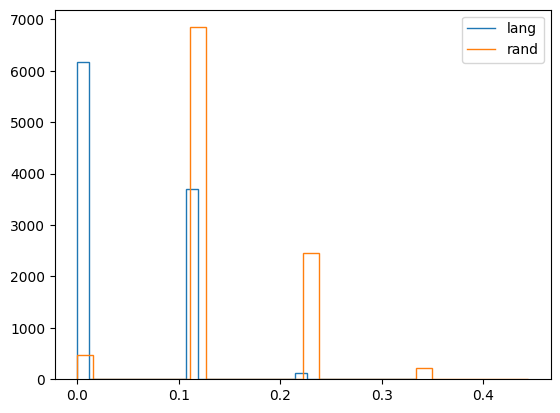

In [10]:
def plot_stat_distr(crit_stat_f, text_len, n_texts):
    lang_stat = []
    rand_stat = []

    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = generate_random_text(text_len)

        lang_stat.append(crit_stat_f(lang_text))
        rand_stat.append(crit_stat_f(rand_text))

    ax = plt.subplot()

    counts1, bins1 = np.histogram(lang_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts1, bins1)

    counts2, bins2 = np.histogram(rand_stat, int(np.ceil(3*np.log(n_texts))))
    ax.stairs(counts2, bins2)

    ax.legend(["lang", "rand"])


n = 10
S = 10000 #int(1000*np.ceil(0.5*np.sqrt(n)))

plot_stat_distr(lambda text: crit_10_stat(text, 1), n, S)


k10 = {1: {10: 0, 100: 0, 1000: 0, 10000: 0},
         2: {10: 0, 100: 0, 1000: 0, 10000: 0}}  

k11 = {1: {10: 1.5, 100: 6.5, 1000: 8.85, 10000: 8.99},
        2: {10: 0.25, 100: 14, 1000: 144, 10000: 225}}   

k12 = {1: {10: 0.0675, 100: 0.035, 1000: 0.0285, 10000: 0.0285},   
        2: {10: 0.06, 100: 0.01, 1000: 0.00315, 10000: 0.0013}}    

k13 = {1: {10: 0.16, 100: 0.14, 1000: 0.15, 10000: 0.16} ,    
        2: {10: 0.075, 100: 0.21, 1000: 0.21, 10000: 0.21}}   

k30 = {1: {10: -1.715, 100: 0.05, 1000: 0.3, 10000: 0.3} ,     
        2: {10: -2.67, 100: -0.88, 1000: 0.18, 10000: 0.45}} 

k51 = {1: {10: 13.5, 100: 1.9, 1000: 0.1, 10000: 0.1} ,   
        2: {10: 300.4, 100: 264, 1000: 108, 10000: 1.25}} 

ks = {10: 2.125, 100: 0.75, 1000: 0.475, 10000: 0.38}   

## Генерування вибірок, перевірка критеріїв та обчислення значення помилок.

Тут:
- FR (false random) - помилка розпізнавання природнього тексту як випадкового (помилка першого роду, або FP (false positive)).
- FL (false language) - помилка розпізнавання випадкового тексту як природнього (помилка другого роду, або FN (false negative)).

In [11]:
def count_errors(rand_text_gen, crit_stat_f, crit_val, text_len, n_texts):
    TL_count = 0
    FL_count = 0

    TR_count = 0
    FR_count = 0
    
    for i in range(n_texts):
        lang_text = generate_rand_lang_text(text_len)
        rand_text = rand_text_gen(text_len)

        CL = crit_stat_f(lang_text)
        CR = crit_stat_f(rand_text)

        if CL <= crit_val:
            TL_count += 1
        else:
            FR_count += 1

        if CR > crit_val:
            TR_count += 1
        else:
            FL_count += 1


    return FR_count / n_texts, FL_count / n_texts


col_names = ["crit_name", "crit_val", "rand_gen", "l_gram", "L", "FL_prob", "FR_prob"]
data = pd.DataFrame(columns=col_names)

rand_gens = [generate_random_text, generate_recur, generate_enc_affine1,
             generate_enc_affine2, 
             lambda text: generate_enc_vigenere(text, 1),
             lambda text: generate_enc_vigenere(text, 5),
             lambda text: generate_enc_vigenere(text, 10)]

rand_gens_names = ["true_rand", "recur_rand", "affine1", "affine2",
                   "vigenere1", "vigenere5", "vigenere10"]


criteria = [crit_10_stat, crit_11_stat, crit_12_stat, crit_13_stat, crit_30_stat, crit_51_stat]
criteria_names = ["1.0", "1.1", "1.2", "1.3", "3.0", "5.1"]
crit_vals = [k10, k11, k12, k13, k30, k51]

n_texts = {10: 10000, 100: 10000, 1000: 10000, 10000: 1000}


for rand_gen in zip(rand_gens, rand_gens_names):
    for L in [10, 100, 1000, 10000]:
        N = n_texts[L]
        for criterion in zip(criteria, criteria_names, crit_vals):
            for l in [1, 2]:
                crit_stat = lambda text, l=l: criterion[0](text, l)
                crit_val = criterion[2][l][L]
                FR_prob, FL_prob = count_errors(rand_gen[0], crit_stat, crit_val, L, N)

                new_entry = pd.DataFrame([(criterion[1], crit_val, rand_gen[1], l, L, FL_prob, FR_prob)], 
                                         columns=col_names)
                data = pd.concat([data, new_entry], ignore_index = True)


C:\Users\Lollo\AppData\Local\Temp\ipykernel_37072\1002958639.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data, new_entry], ignore_index = True)


In [12]:
for rand_gen in zip(rand_gens, rand_gens_names):
    for L in [10, 100, 1000, 10000]:
        N = n_texts[L]
        criterion = [deflate_compression_ratio, 'deflate structural', ks]
        
        crit_val = ks[L]
        FR_prob, FL_prob = count_errors(rand_gen[0], deflate_compression_ratio, crit_val, L, N)

        new_entry = pd.DataFrame([('deflate structural', crit_val, rand_gen[1], None, L, FL_prob, FR_prob)], 
                                    columns=col_names)
        data = pd.concat([data, new_entry], ignore_index = True)

## Форматування даних та виведення в табличку

In [21]:
print(len(data.index))
data = data.sort_values(by=['rand_gen', 'L', 'l_gram', 'crit_name'])
data.head(50)

with pd.ExcelWriter('full_results.xlsx', mode='a') as w:
    data.to_excel(w, sheet_name='All Probs')

364


## А далі ручна праця...